# 배경
아마존 : 아이템-아이템 상호 필터링 사용

아이템-아이템 상호 필터링
- scales to massive datasets and produces high quality recommendation system in the real time
- a kind of a information filtering system which seeks to predict the "rating" or preferences which user is interested in.

# 추천 시스템 입문
-Recommeder system creates a similarity between the user and items and exploits the similarity between user/item to make recommendations.

# 추천 종류
1. Popularity based systems :- It works by recommeding items viewed and purchased by most people and are rated high.It is not a personalized recommendation.
2. Classification model based:- It works by understanding the features of the user and applying the classification algorithm to decide whether the user is interested or not in the prodcut.
3. Content based recommedations:- It is based on the information on the contents of the item rather than on the user opinions.The main idea is if the user likes an item then he or she will like the "other" similar item.
4. Collaberative Filtering:- It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types: a) User-User b) Item -Item
5. Hybrid Approaches:- This system approach is to combine collaborative filtering, content-based filtering, and other approaches .
6. Association rule mining :- Association rules capture the relationships between items based on their patterns of co-occurrence across transactions

# 속성 정보
-  userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating ( ignore this column for this exercise)

# 필요한 라이브러리 임포트하기

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# 데이터 불러오기 + head 보기

In [3]:
electronics_data=pd.read_csv("/content/sample_data/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [4]:
# Display the data

electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [5]:
#Shape of the data
electronics_data.shape

(77618, 4)

In [6]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [7]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp    float64
dtype: object

In [8]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77618 entries, 0 to 77617
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     77618 non-null  object 
 1   productId  77617 non-null  object 
 2   Rating     77617 non-null  float64
 3   timestamp  77617 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.4+ MB


In [9]:
#Five point summary

electronics_data.describe()['Rating'].T

count    77617.000000
mean         4.055336
std          1.339192
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

In [10]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


# 결측값 처리하기

In [11]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    1
Rating       1
timestamp    1
dtype: int64


# 비율 확인하기

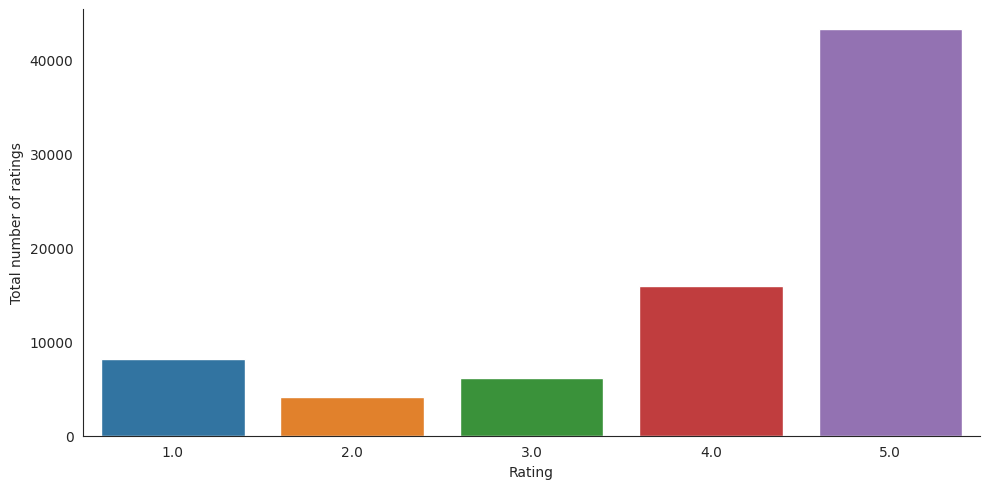

In [13]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

# unique값 확인하기

In [14]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 77618
Total No of Users   : 70713


TypeError: ignored

# TimeStamp Column 제거하기

In [15]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

# 비율 분석하기

In [16]:
#Analysis of rating given by the user

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A231WM2Z2JL0U3    67
A2BGZ52M908MJY    45
AY8Q1X7G96HV5     36
A1MJMYLRTZ76ZX    29
A1NVD0TKNS1GT5    29
Name: Rating, dtype: int64

In [17]:
no_of_rated_products_per_user.describe()

count    70713.000000
mean         1.097634
std          0.655332
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         67.000000
Name: Rating, dtype: float64

In [18]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

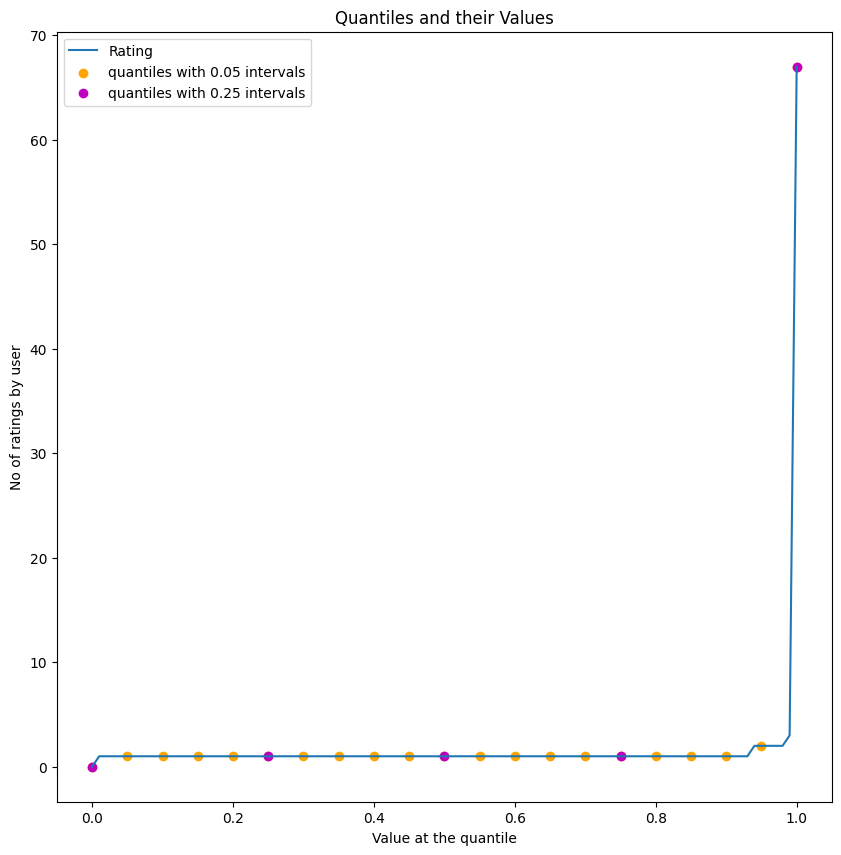

In [19]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [20]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 1



# popularity based recommendation

In [21]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, ''),
 Text(200.0, 0, ''),
 Text(250.0, 0, ''),
 Text(300.0, 0, '')]

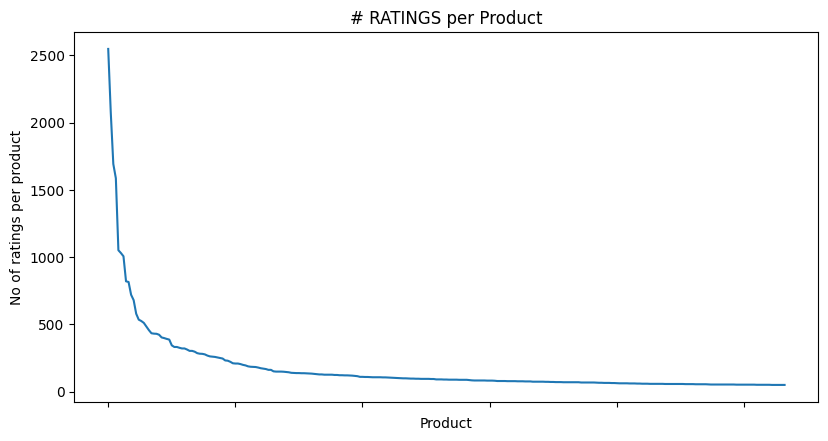

In [22]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [23]:
#Average rating of the product

new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [24]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B00004TDLD    4.840517
B00004TENT    4.823529
B00004Y2MM    4.808824
B00004XOM3    4.794613
B00004Z5KA    4.754717
Name: Rating, dtype: float64

In [25]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B00004ZCJE    2547
B00001P4ZH    2075
B00004T8R2    1692
B00001WRSJ    1586
0972683275    1051
Name: Rating, dtype: int64

In [26]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [27]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [28]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [29]:
ratings_mean_count['rating_counts'].max()

2547

<Figure size 800x600 with 0 Axes>

<Axes: >

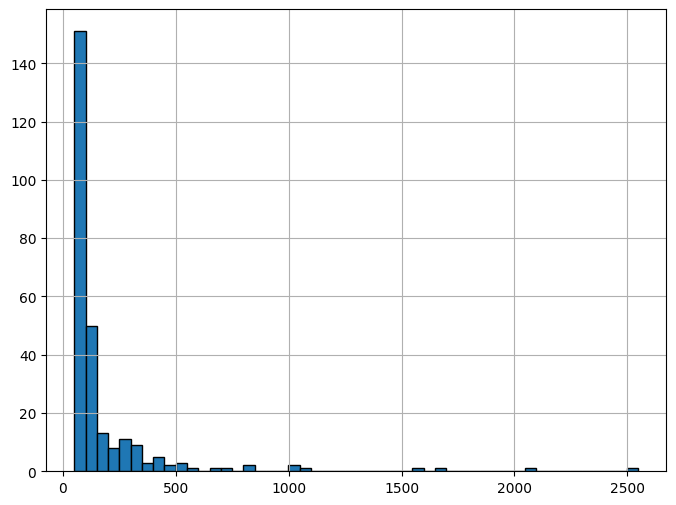

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Axes: >

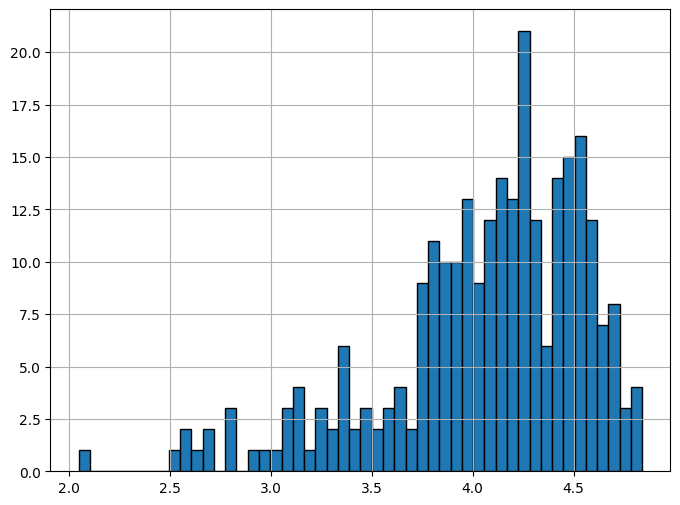

In [31]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

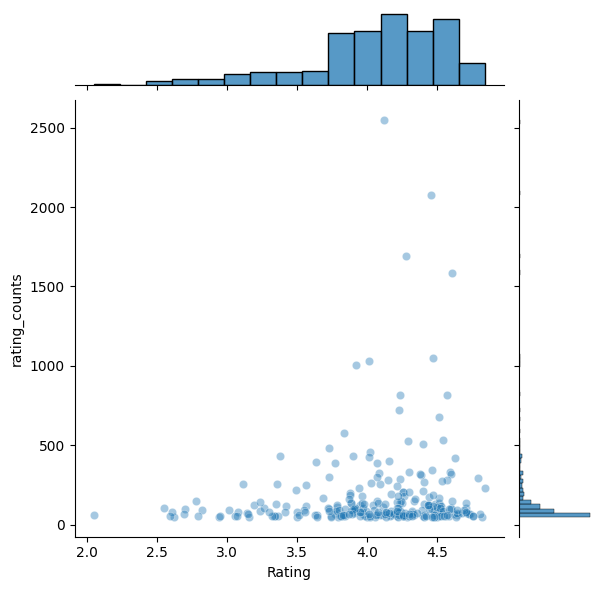

In [32]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='productId'>

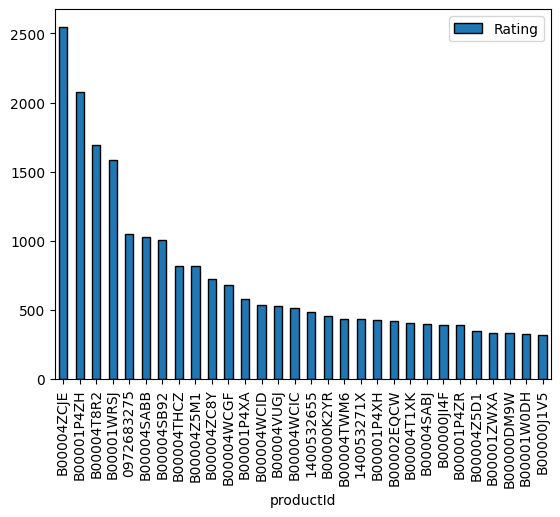

In [33]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# collaberative filtering (item-item recommendation)

In [38]:
! pip install scikit-surprise

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163486 sha256=4411e0c95bb9f63a4b3c3ef71f7fb22677cdb949299707cebf7b67860a0a0605
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [40]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [41]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [42]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [43]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [44]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [45]:
test_pred

[Prediction(uid='A3ENIUT77P8BBI', iid='B00004RIUJ', r_ui=5.0, est=4.150881896000244, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ALZQKKKZ6VT0H', iid='B00000DM9W', r_ui=3.0, est=4.150881896000244, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1JZSJ64NA4FQX', iid='B00000JI4F', r_ui=5.0, est=4.150881896000244, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A11FZVPW6VQ1KV', iid='B00004VX15', r_ui=5.0, est=4.150881896000244, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AN9SN664D8E8Z', iid='B00004XO1V', r_ui=1.0, est=4.150881896000244, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3DY8TXYKMO8YI', iid='9573212919', r_ui=5.0, est=4.150881896000244, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1FUJ5WV85Z48

In [46]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2811


1.281146295986459

# model based collaborative filtering system

In [47]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
ratings_matrix.shape

(9832, 76)

In [49]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
X.shape

(76, 9832)

In [51]:
X1 = X

In [52]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [53]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [54]:
X.index[75]

'B00000K135'

In [55]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [56]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [57]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:24]

['9573212919',
 'B000001OM4',
 'B000001OM5',
 'B00000IGBF',
 'B00000J05A',
 'B00000J1U8',
 'B00000J1UQ',
 'B00000JDHV']